# Creating our first Context

## Basics of the basics

In [1]:
import os

import findspark
import pyspark
import time
import operator

In [2]:
from pyspark import SparkConf
from pyspark import SparkContext


conf = SparkConf()
conf.setMaster("local")
conf.setAppName("spark-basic")
sc = SparkContext(conf = conf)

What does this function do?

In [ ]:
def surprise(x):
    for i in range(2,x):
        if (x % i) == 0:
            return(x,"No")
    return(x,"Yes")

In [ ]:
rdd = sc.parallelize(range(2,10000)).map(surprise).take(20)

In [ ]:
print(rdd)

#### Warming up Exercise: Smarter way?

**Option 1**

In [ ]:
start_time = time.time()

rdd = sc.parallelize(range(2,int(5e4))).map(surprise).take(int(5e4))

print("--- %s seconds ---" % (time.time() - start_time))

**Option 2**

In [ ]:
def is_prime(n):
    """
    Assumes that n is a positive natural number
    """
    # We know 1 is not a prime number
    if n == 1:
        return False

    i = 2
    # This will loop from 2 to int(sqrt(x))
    while i*i <= n:
        # Check if i divides x without leaving a remainder
        if n % i == 0:
            # This means that n has a factor in between 2 and sqrt(n)
            # So it is not a prime number
            return False
        i += 1
    # If we did not find any factor in the above loop,
    # then n is a prime number
    return True

In [ ]:
start_time = time.time()

rdd = sc.parallelize(range(2,int(5e4))).map(is_prime).take(int(5e4))

print("--- %s seconds ---" % (time.time() - start_time))

- What happens if we reduce the value of the function take()?
- What happens if we don't use the function take() ?

## A bit more...

### Persistance

- RDDs in python are lazily evaluated, so if we are planning to reuse multiple times the same RDD, we will be recomputing it that many times
- To avoid this, we can force our program to persist the data

Let's see the persisting approach:

In [ ]:
rdd = sc.parallelize(range(2,int(1e9)))
rdd.cache()

start_time = time.time()

rdd.map(is_prime).take(10000)

print("--- %s seconds ---" % (time.time() - start_time))

Against the normal one:

In [ ]:
rdd = sc.parallelize(range(2,int(1e9)))

start_time = time.time()

rdd.map(is_prime).take(10000)

print("--- %s seconds ---" % (time.time() - start_time))

And same happens with the function cache()... What? Why?

### And what about text?

In [ ]:
file = open("Quijote.txt","r", encoding='utf-8').read()

In [ ]:
rdd = sc.textFile(file)

In [ ]:
rdd

# More theory... again

## Transformations vs Actions

In a nutshell:

**Transformations** create new rdds\
**Actions** give us values

## Transformations

- Are lazy, really lazy!
- Create dependencies, chains of transformations
- Trigger

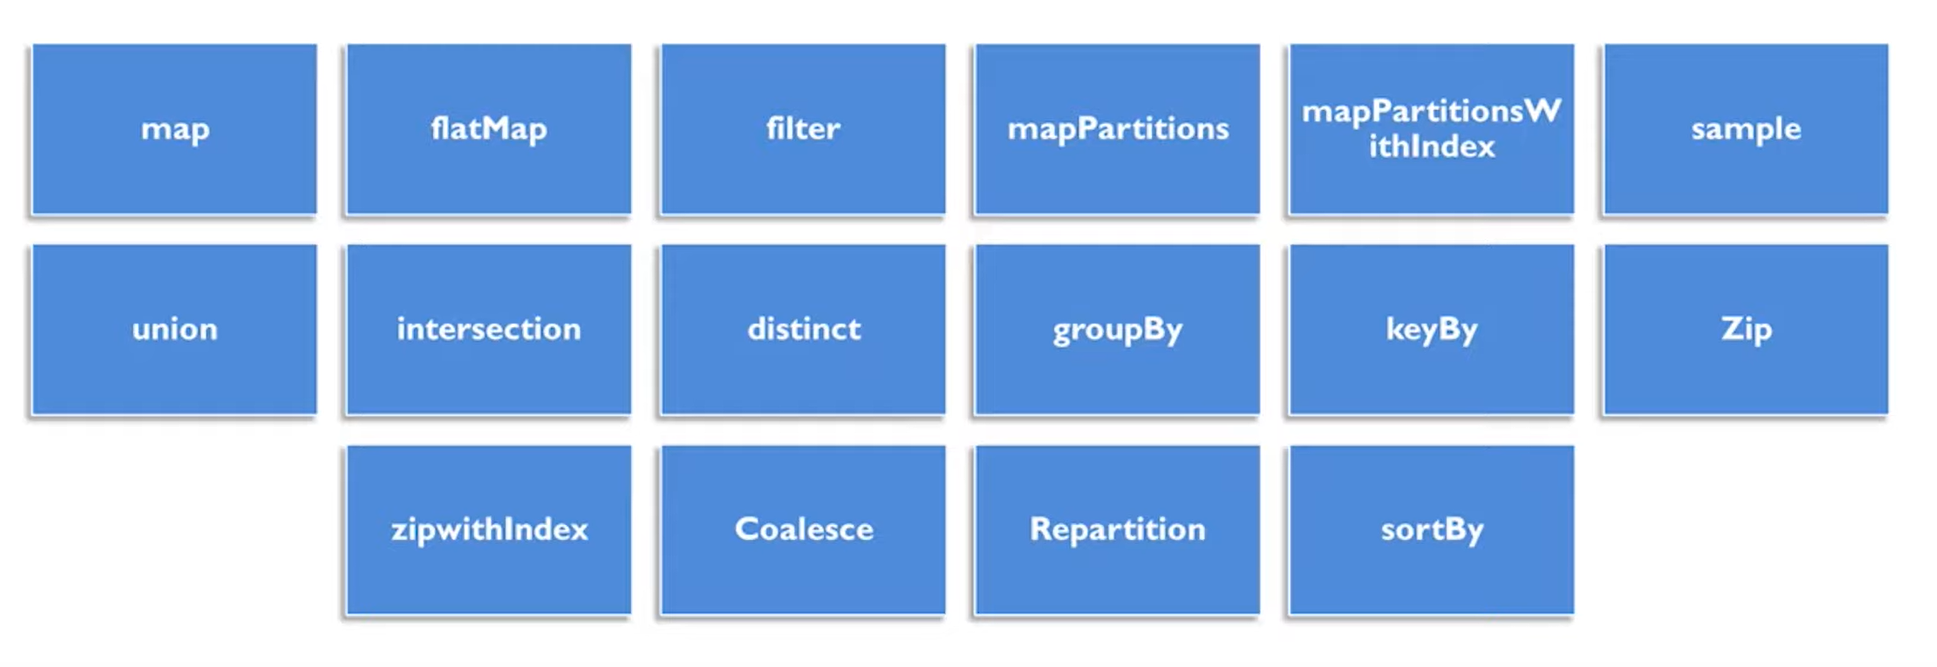

#### Map

In [ ]:
x = sc.parallelize(["A","B","C","D","D"])
y = x.map(lambda x:(x,1))
y.collect()

By the way... collect is not a transformation, but an action!

#### Flatmap

In [ ]:
x = sc.parallelize([1,3,4,5])
sorted(x.flatMap(lambda x: range(1,x)).collect())

Try to explain what flatmap does. What is the difference with map? Can you explain what is going on here?

#### Filter

In [ ]:
x = sc.parallelize(range(1,20,3))
x.filter(lambda x: x%2 == 0).collect()

Define a function that, given a list of strings, is able to keep only e-mail adresses.

In [3]:
import re
def is_email(s):
    list_emails = []
    regex_01 = "[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+"
    emails = re.findall(regex_01, s)
    for mail in emails:
        list_emails.append(mail)
    return list_emails

In [21]:
test_string = ['some@yahoo.com','someone', 'facebook.com' , 'k@gmail.com' , 'tap@' , '.com']

emails_rdd = sc.parallelize(test_string)
emails_rdd.filter(is_email).collect()

['some@yahoo.com', 'k@gmail.com']

In [10]:
is_email("this is not an email email@email.com and stuff")

['email@email.com']

#### Sample

Search how to use the transformation sample(), which parameters are needed?

Code a function that, using pyspark, returns the sum of k dices of m sides. So dice(k = 3, m = 6) would return values between 3 and 18.

In [6]:
rdd = sc.parallelize(range(2,int(1e3)))

In [33]:
import random

def sumdice(k,m):
    suma = 0
    for i in range(k):
        suma += sc.parallelize(range(1,m+1)).sample(fraction = 1, withReplacement = True).collect()[0]
    return suma

In [34]:
for i in range(10):
    print(sumdice(3,6))


4
6
5
5
7
6
7
4
7
3


Code a function that generates lottery numbers between 00000 and 99999.

##### Union and intersection

In [ ]:
x = sc.parallelize(range(0,10))
y = sc.parallelize(range(6,12))
print(x.union(y).collect())
print(x.intersection(y).collect())

Are they symmetric?
Think about a real world application (on social media, for example....) of these two transformations

Code a function that depends of 2 lists, and returns the values that are unique in the first list (www.google.com)

In [ ]:
#### Your code here

##### Distinct

Explore the transformation distinct, and find a meaningful example where it can be useful

In [ ]:
#### Your code here

#### Sortby

In [ ]:
sc.parallelize([1,3,4,6,2,3,4,5,1]).sortBy(lambda x: x, True ).collect()

In [ ]:
sc.parallelize([("A",1),("B",2),("C",3),("D",4)]).sortBy(lambda x: x, False ).collect()

Wait wait... what is it really doing here? Explore a bit!

#### MapPartitions

In [ ]:
x = sc.parallelize([1,2,3,4,5],2)
def func(x): yield sum(x)

x.mapPartitions(func).collect()

What is going on? What are these numbers? Experiment a bit!

Once you have it clear, check the differences between mapPartitions and map PartitionsWithIndex

#### Groupby

In [ ]:
x = sc.parallelize([1,1,2,3,4,5,6,8,9])
groups = x.groupBy(lambda x: x % 3).collect()
sorted([(x,sorted(y))] for (x,y) in groups)

Create a function that, given a list of different texts, detects how many times a word(s), appears on it. 

For example, to detect if an article is talking about FCB, check if the words "Messi", "Setien" or "Barça" appear.

In [ ]:
#### Your code here

#### Zip

In [ ]:
sc.parallelize(range(0,5)).zip(sc.parallelize(range(20,25))).collect()

Does it have any restrictions? What happens if we give different lengths? What would R do?

#### Repartition and coalesce

In [ ]:
x = sc.parallelize(range(0,20),6)
x.glom().collect()

In [ ]:
print(x.repartition(2).glom().collect())

print(x.coalesce(2).glom().collect())



What is the criteria? Experiment a little

#### Reduce

In [ ]:
from operator import add

sc.parallelize(range(0,100)).reduce(add)

Why add and not sum?

## Actions

- They produce values back to the Spark program
- They make transformations start moving!

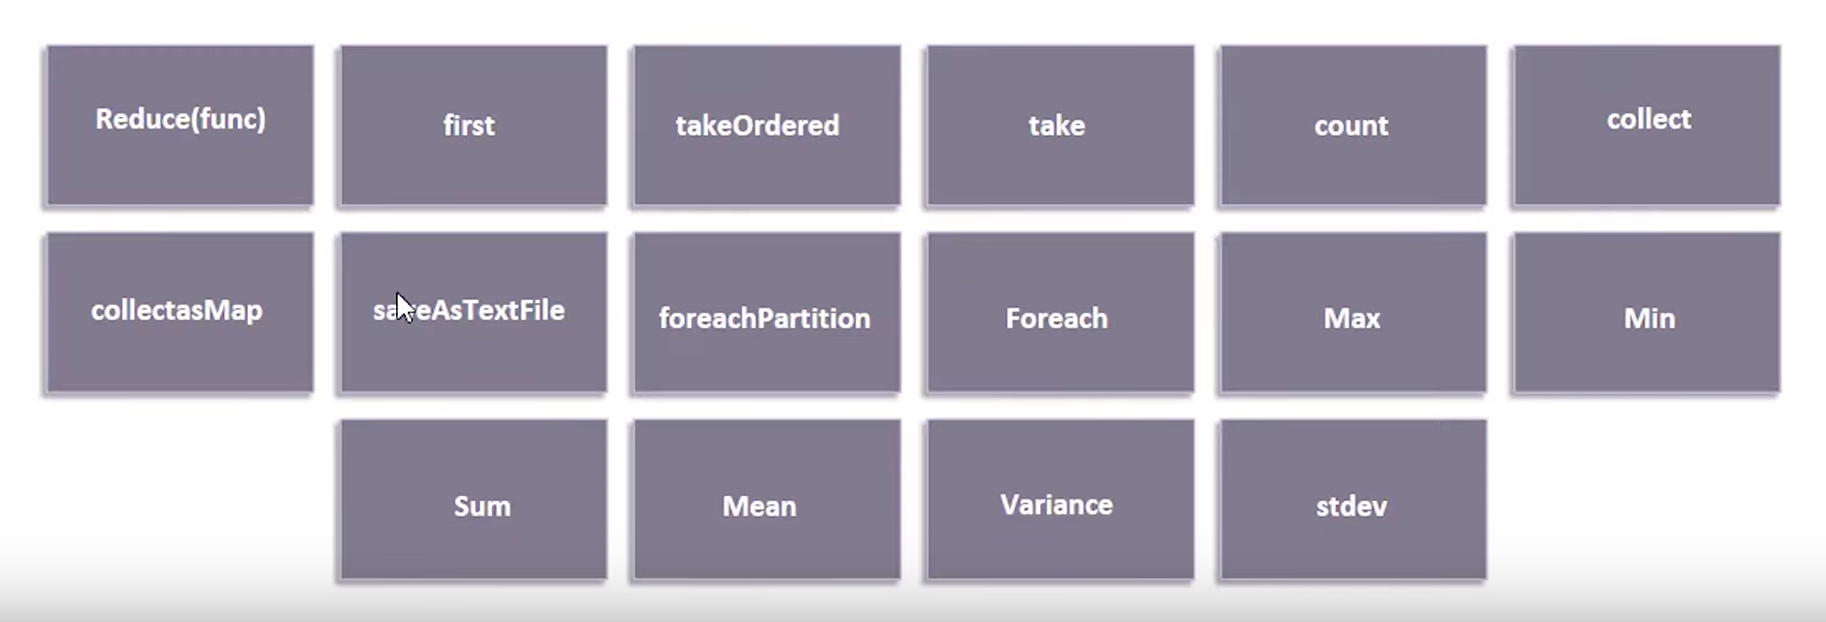

#### Reduce

In [ ]:
from operator import add

sc.parallelize(range(0,100)).reduce(add)

Why add and not sum?

Hint:

In [ ]:
def prod(a,b):
    return(a*b)

sc.parallelize(range(1,10)).reduce(prod)

#### First and TakeOrdered

In [ ]:
x = sc.parallelize([11,1,3,5,4,2,7,8,1,6,5,11])

print(x.first())

print(x.takeOrdered(6))

How would you select the last 3? And the last 3 without repetitions?

#### Max, min, sum, mean, variance, stdev, count....

Create a function that computes the coefficient of variation of a numeric list. If you don't know what it is... what better time than now to learn it?!

Create a function that converts a numeric list into a percentage list

In [ ]:
#### Your code here

#### Countbyvalue

In [ ]:
sc.parallelize([1,2,5,4,6,8,7,2,3,4,3,1,6,7,3,2,1]).countByValue()

## Some functions and more transformations (with paired RDDs)

#### Reducebykey and groupByKey

In [ ]:
x = sc.parallelize({(1,2),(2,1),(1,3),(3,3),(4,1)})
print(x.reduceByKey(add).collect())
x.groupByKey().collect()

Describe and code a real world application with these functions. Try to incorporate other actions/transformations to make it more meaningful

In [ ]:
#### Your code here

#### mapValues and flatMapValues

Explore how these two transformations work, and find a working example for them

In [ ]:
#### Your code here

#### Keys, sortByKey and substractByKey

In [ ]:
x = sc.parallelize({(1,2),(2,1),(1,3),(3,3),(4,1)})
x.keys().collect()

In [ ]:
x.sortByKey().collect()

In [ ]:
y = sc.parallelize({(1,6),(5,3)})
x.subtractByKey(y).collect()

#### Joins!!!

Explore the transformations .join(), .rightOuterJoin(), .leftOuterJoin() and .cogroup()

Work with the following data:

In [ ]:
x = sc.parallelize({("A",2),("B",1),("A",3),("C",3),("D",1)})
y = sc.parallelize({("D",1),("A",7),("B",3),("A",9),("E",3),("F",4)})

In [ ]:
#### Your code here

### Exercise

Code a word count program that gives you the top 100 words of "El Quijote". The order you perform the operations is really important here!

In [ ]:
#### Your code here

List of hints:
- First try to split the words before transforming them into a rdd
- You need to assign each of the words a value 1, we have seen how to do it
- After that, you will need to use the word (the key) to sum the 1s
- Almost done, but we would like to see the top... is the dictionary in the right order?

#### One possible solution... don't look!
Explain line by line what is going on!

In [ ]:
import re

file = open("Quijote.txt","r", encoding='utf-8').read()
words = file.split(" ")
words = sc.parallelize(words)
# words = words.map(lambda x: re.sub(r'[^\w\s]','',x)) # Try it with and without this line
wordcount = words.map(lambda x: (x,1)) 
wordcount = wordcount.reduceByKey(add) # Alternatively wordcount.reduceByKey(lambda x,y: x+y)
wordcount = wordcount.map(lambda x: (x[1],x[0]))
wordcount.sortByKey(False).take(50)

### Another Exercise!

Let's code a shopping list!
We will have a list of elements like this:
    
x = sc.parallelize([["Apple",3,0.2],["Pear",5,0.35],["Milk",2,1.1],["Apple",3,0.2]])

Where the first element of each list is the product, the second the number of unit we bought and the third the unit price.

We want to have the list of how much we have spent in each product (ordered), and the total amount of money we have spent. 

(Optional) If we buy more than 10 products of the same type, we have a 10% discount of the final price

In [ ]:
x = sc.parallelize([["Apple",3,0.2],["Pear",5,0.35],["Milk",2,1.1],["Apple",3,0.2]])

### Last one...

Replicate the last exercise, but the structure of the data is different. We have one object with products and prices. On the other hand, we have one list of the following form:

x = sc.parallelize([["Maria","Apple",1],["Maria","Pear",2],["Pau","Milk",4],["Laura","Apple",3]])

We want to know how much each of the have spent in total.

In [ ]:
#### Your code here

In [ ]:
sc._jsc.sc().uiWebUrl().get()